# ASTR 596 Computer lab - Characterizing CCDs (50 points)

In this lab you will learn how to:
* read in a CCD image into python
* learn how to display a CCD image
* measure properties of that CCD image
* from a set of CCD Bias frames and Flat field frames, determine the readnoise and gain of the CCD

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on Nov. 3 at Noon** to be handed into the "Characterizing CCDs" assignment in Module 6.

### Import modules

In [2]:
import os
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import scoreatpercentile
import glob
%matplotlib inline
from astropy.nddata import CCDData
import astropy.units as u
from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project

### Define a function for displaying images

* We will want to look at images as we examine and analyze the data, so here will will define a function for displaying images. 
* This will handle getting the stretch of the image correct. 
* Feel free to play with the settings and colormap once you get the hang of the process.



In [3]:
def imdisplay(image, v1perc=10, v2perc=95):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    plt.imshow(nimage,cmap='gray_r',vmin=v1,vmax=v2)
    plt.colorbar(fraction=.08)

### Display raw science image

Text(0.5, 1.0, 'V-band Raw image')

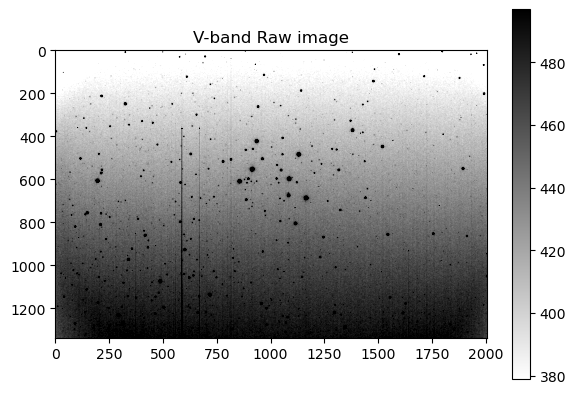

In [4]:
plt.figure()
data_vimraw, header_vimraw = fits.getdata('M29-0005g.fit',header=True)
imdisplay(data_vimraw)
plt.title("V-band Raw image")

### Display processed science image

Text(0.5, 1.0, 'V-band Processed image')

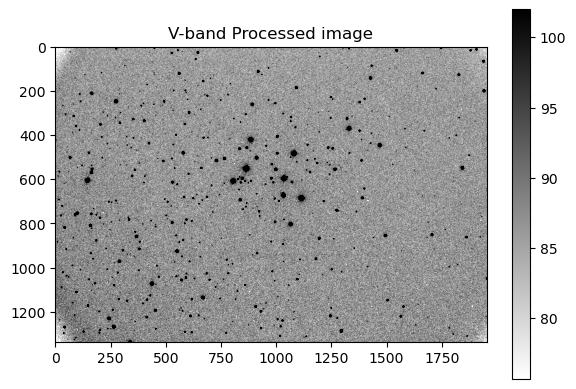

In [5]:
plt.figure()
data_vimproc, header_vimproc = fits.getdata('cazfdp-M29-0005g.fits',header=True)
imdisplay(data_vimproc)
plt.title("V-band Processed image")

## Problem 1 (5 points)

The two images above are the same exact image except that one is raw and one has been fully processed.  In the cell below, describe the origin of the differences between the two images.  I want you to be precise.  NOTE: This CCD has no overscan region so we only have the combined bias frames.  Also pay attention to the values in the colorbar.

answer goes here: The unprocessed image is the raw data, or the number of photoelectron counts without taking the bias, dark, and flat frame into account. From the raw image, first the bias frame is removed. The bias is a 0 second exposure with no light. There are multiple bias frames, which can be combined using either the median of each pixel value across all the bias frames, or sigma clipping, which entails rjecting certain pixel values that are some multiple of the standard deviation (sigma) away from the mean. The bias is an additive offset, so it can be added or subtracted from the raw image. Next we remove the dark frame. This is a bias frame for some given exposure time that shows thermally excited electrons masquerading as
photoelectrons. We first want to remove the bias from each dark frame, then combine all the dark frames by taking the median of all the values at a given pixel. The dark frame is also an additive offset. We finally remove the flat frame. We can make a flat frame by exposing the detector to a constatant source of light and removing the dark and bias frames from the linear response part of your flatfeild images and normalize it to the median of one. You can then find the combination of all the flat feilds and devide the raw image by the master flat. The maximum number in the color bar decreases indicating the total number of counts is less in the processed image. This makes sense as both the bias and dark frames remove counts from pixels caused by thermal exitation, cosmic rays, or deffective pixels. The bright vertical lines and brigter gradient towards the bottom of the image were removed when subtracting the bias. This is shown later in the lab as the bias frames show these properties. The lower counts around the edge of the processed image is likely due to the removal of the flat feild, as the flat displays lower counts around the corner of the frame. The flat frame also removes annuli of lower counts as shown in the flat images.  

### Display two flat field images

Text(0.5, 1.0, 'B-band Sky Flat')

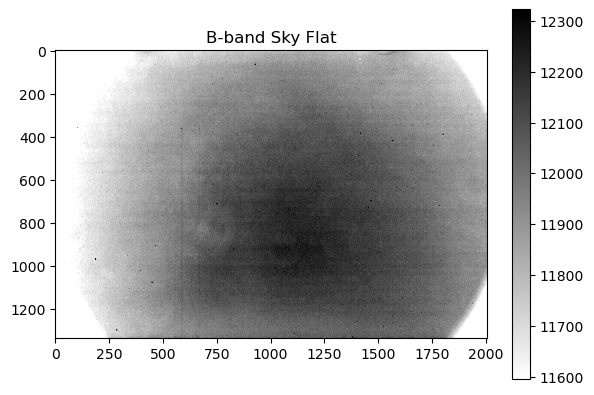

In [6]:
plt.figure()
data_flatb, header_flatb = fits.getdata('skyflat-0001b.fit',header=True)
imdisplay(data_flatb,v2perc=99)
plt.title("B-band Sky Flat")

Text(0.5, 1.0, 'V-band Sky Flat')

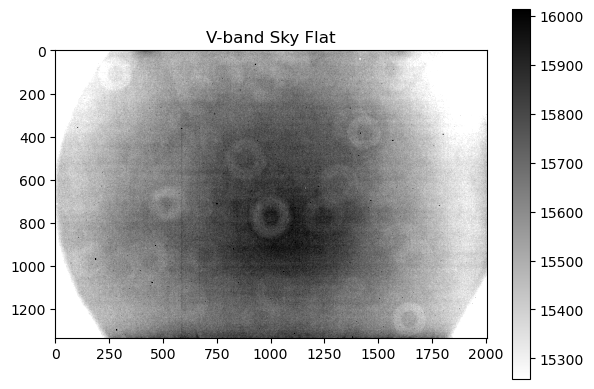

In [7]:
plt.figure()
data_flatv, header_flatv = fits.getdata('skyflat-0001v.fit',header=True)
imdisplay(data_flatv,v2perc=99)
plt.title("V-band Sky Flat") 

## Problem 2 (5 points)
The two images above are two different flat field images.  The total number of counts depends on the brightness of the sky in the filte ryou are using at the time of observation.  Aside from a difference in the total counts, describe what the origins could be of the differences in the flatfields.  Pay attention to differences both at the large scale and the short scale.  

It is not required for the problem, but if you would like to better understand the differences between the two images, you can write a short bit of code that divides the two data arrays and then displays them.

answer goes here: In the V-band, we are looking at photons of a shoter wavelength that are more suseptible to being scattered by small dust particles, which is what we see in the V-band flat feild. The anulus in the V-band flap appear to be out of focus dust particles blocking the light. The quantum efficiency of the detector in each band may also be causing differecnces in the images, given detectors do not have the same efficiency over different wavelengths. The B-band has lower counts, so the detector may have a worse quatum efficiency in this band, but this also may be due to the variance in sky brightness at different bands. 

### Display or manipiulate a section of an image

You can feed sections of images to functions and they will either perform the necessary operations, or in the following case, display only those sections.  You may find it useful to consult the first python notebook we did, which had instructions on how to slice arrays.

## Problem 3 (5 points) - properly display a region of the image

You will need to complete the section of code below to display rows 400-900 and columns 750-1250.  You must compare the cutout to the full image above to make sure you are properly addressing rows and columns.

Text(0.5, 1.0, 'cutout of V-band image')

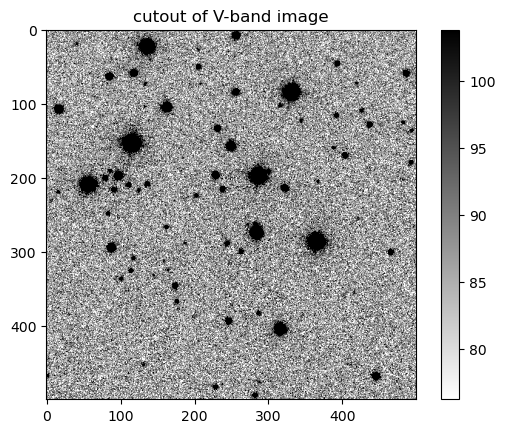

In [8]:
#to display only a section of an image you can perform the following operation
#this displays the section of the image
#***************** fill in the missing array range.
#display image from colums 400-900 (python starts at 0, so actually 399-899), and rows 750-1250 (749-1249)
imdisplay(data_vimproc[399:899,749:1249])
plt.title("cutout of V-band image")
#NOTE: that it renumbers the pixels and does *not* refer back to the original image.  
#It also bases the colorbar stretch on the pixels in the subsection that you are displaying

#### Compute statistics on an image
You can pass an image to numpy and compute statistics on it.  In the example below, I show how to compute the standard deviation of all pixel values of a bias image.

I have included two bias images in this directy, numbers 20 and 21


the standard deviation of the Bias frame is 42.081744983055124


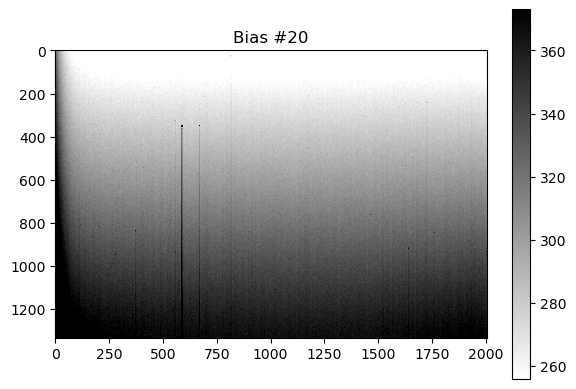

In [9]:
#first read in a bias image
plt.figure()
data_bias1, header_bias1 = fits.getdata('bias-0020.fit',header=True)
imdisplay(data_bias1)
plt.title("Bias #20")

print("the standard deviation of the Bias frame is", np.std(data_bias1))

## Problem 4 (5 points) - Compute the standard deviation of a subsection of the bias image
I would like you to write a peice of well-commented code that
1. displays the bias image extending over rows 600-800 and columns 1000-1200.
2. Measure the standard deviation of the pixels in this section of the bias and print it out.

Then I would like you to explain any differences in the stanard deviation between this subsection and that of the full image.


the standard deviation of the Bias frame subsection is 12.980392044926841


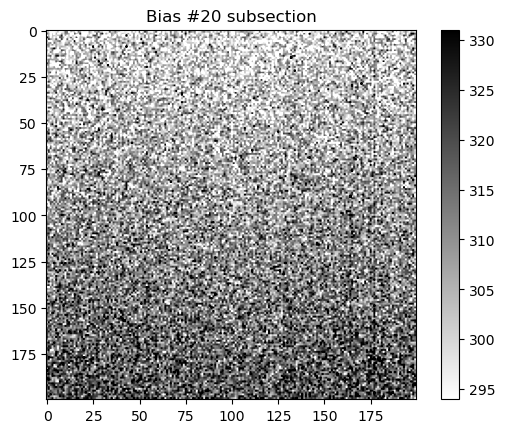

In [10]:
#Put your code here
#***********************
#plot the figure
plt.figure()
data_bias1, header_bias1 = fits.getdata('bias-0020.fit',header=True)
#display image from colums 600-800 (python starts at 0, so actually 599-799), and rows 1000-1200 (999-1199)
imdisplay(data_bias1[599:799,999:1199])
#plot the subsection of rows and columns above as plot titled "Bias #20 subsection"
plt.title("Bias #20 subsection")
#display the standard deviation of the subsection of bias 20 described by the columns and rows above as "the standard deviation of the Bias frame subsection is"
print("the standard deviation of the Bias frame subsection is", np.std(data_bias1[599:799,999:1199]))



put your answer here: The standard deviaiton in the subsection is smaller than the standard deviation over the entire bias because it is only slecting a localized area of the detector over a smalle interval, leading to less deviaiton from pixel to pixel over a subsection compared to the entire bias, which appears to have a gradient of pixels with lower photoelectron counts at the top of the images compared to the bottom. Given we are only looking over this smaller area, the gradient will not be as intense over the subsection. In other words, the difference of each pixel from the mean will have a larger absolute value over the whole bias than over the subsection for reasons previosly described. 

## Problem 5 (15 points) - compute the readnoise from two bias frames
Using the coding tools we described above and have used in the class, I would like you to 
1. write a well-commented program that measures the READNOISE using two bias frames and prints it out.  The name of the second bias frame is `bias-0021.fit`, which I have written code to read in. You cannot just use the answer from the question above, which was derived from one bias frame.
2. Describe why you can't jsut use one bias frame.
3. Comment on whether the number you derived is in electrons or ADU and justify your answer.

In [11]:
#read in the other bias image
data_bias2,header_bias2 = fits.getdata("bias-0021.fit",header=True)

#convert both arrays to floating point arrays.  This is needed to make sure that
#arithmetic operations will work as the images are otherwise positive definite (UNSIGNED) integers.
data_bias1 = np.array(data_bias1,"f")
data_bias2 = np.array(data_bias2,"f")

#*******************
#Your code here
#first want to take the standard deviation of each bias frame (data_bias1, data_bias2) to find the uncertainty of each bias. These standard deviaitons 
#are defined as sigma1 for the std dev on the first frame and and sigma2 for the std dev on the second frame. 
sigma1=np.std(data_bias1)
sigma2=np.std(data_bias2)
#to find the std of the difference in the two bias frames (data_bias1-data_bias2), we need to propagate the uncertainty of both bias frames std dev.
#we define this as readnoise = squaroot(sigma1^2+sigma2^2)
readnoise=np.sqrt((sigma1)**2+(sigma2)**2)
#display the readnoise
print("Readnoise of Bias Frame in ADU is = ",readnoise)

Readnoise of Bias Frame in ADU is =  59.44182905511347


put answer to part 2 and 3 here: Readnoise is the random noise variance from pixel to pixel of the detector. By finding the standard deviation of the differnce in the two bias frames though propagation of error can better isolate and measure the read noise. The resulting image eliminates any noise due to the sensor and electronics, leaving behind only the read noise component. With only one bias, finding the standard deviation would only tell you how each pixel varies from the total average of all the pixels as opposed to the varience over just the average variance per each pixel. Only one bias would still include background and other noise in the standard deviation. This derived number is in ADU because the the CCD reads the number of ADU and not the number of electrons given most ADUs cannot count high enough to account for all of the electrons.                                                                       

## Problem 6 (15 points) - Compute gain of detector using flat field
1. Using your answer to Problem 5 and statistics of the B-band flat field image above, you will need to write a program that computes the gain of the CCD and prints it out.  Specify the units of the gain.  This will work for any flat-field image, but I just used the B-band (`data_flatb`) so that everyone is on the same page.

2. Include a text field with your mathematical derivation in LaTeX, which you can included in the text field.

3. Check your answer against the value in the header.  You can bring this value using `print(header_flatb['EGAIN'])`, where EGAIN is the header keyword for the gain.  Compute how accurate your estimate is.

**HINT:** You will need to think about the measured standard deviation of the pixel values in a section of the flatfield that is relatively uniform.  You can use that, and your knowledge of Poisson statistics and the way the gain affects the counts, to compute the gain.

In [35]:
#*********** 
#your code goes here


#define sigma_ADU as the standard deviation of the data flat in the b filter over rows 799-999 and coulmns 999-1249 (flat is relatively
#uniform over this range), this is our uncertainty in the adu count. Given a flat feild should be a source of uniform light, the standard deviation of
#the flat should approximate the uncertainty in ADU, however given the flat is not perfect, it will lead to a difference in calcu;ated vs known gain. 
sigma_ADU=np.std(data_flatb[799:999,999:1249])
#define N_ADU is the mean of the data flat in the b filter over rows 799-999 and coulmns 999-1249 (flat is relatively
#uniform over this range), this is our average count per pixel over this range in the b flat
N_ADU=np.mean(data_flatb[799:999,999:1249])

#define gain as N_ADU/sigma_ADU as derived in the LaTeX file
gain=N_ADU/sigma_ADU**2
#define percent as (known gain-estimated gain)/((known gain+estimatd gain)/2). This is the difference in the two values over the average of the values)
percent=((header_flatb['EGAIN']-gain)/((gain+header_flatb['EGAIN'])/2))*100

print("gain = ", gain)
print("gain from header keyword = ", header_flatb['EGAIN'])
print("percentage differece = ", percent)

gain =  1.2978245274108091
gain from header keyword =  1.6200000047683716
percentage differece =  22.083266063771514


Gain derivation

We know the electron count ($N_e$) is a relation between the gain ($g$) and ADU count ($N_{ADU})$.
\begin{equation}
    N_e=gN_{ADU}
\end{equation}
To find the uncertainty in $N_e$ ($\sigma_e$), we must propagate the uncertainty of equation (1) in the following way:
\begin{equation}
    \sigma_e=\sqrt{(\frac{\partial N_e}{\partial N_{ADU}}\sigma_{ADU})^2+(\frac{\partial N_e}{\partial g}\sigma_{g})^2}
\end{equation}
We know that there is no uncertainty on the gain, so $\sigma_g=0$, meaning the second term of equation (2) drops out:
\begin{equation}
    \sigma_e=\sqrt{(g\sigma_{ADU})^2}=g\sigma_{ADU}
\end{equation}
Given we know $N_e=\sigma_e^2$, we can plug equation (3) into equation (1) to get an expression for $g$ in terms of $\sigma_{ADU}$ and $N_{ADU}$.
\begin{equation}
    N_e=\sigma_e^2=(g\sigma_{ADU})^2=g^2\sigma_{ADU}^2=gN_{ADU}
\end{equation}
Solving for $g$, we get the final expression:
\begin{equation}
    g=\frac{N_{ADU}}{\sigma_{ADU}^2}
\end{equation}
